<a href="https://colab.research.google.com/github/noo-rashbass/synthetic-data-service/blob/master/Evaluation/predictive_model_PROGRESS_Lulu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit

# Data Loading Tools

Steps 1 and 2

Lulu: make_time_windows and make_x_y is similar to Aisha's data_label_split and data_divide. Differences:
* make_x_y requires a single column to be selected and builds y's from it
* make_time_windows fixes the sequence length and drags the window down each participant's timeseries (not the concatenated npy with all visits)

To do:
* Normalisation/Scaling

In [2]:
def load_DoppelGANger():
  ori_data = np.load('ori_features_prism.npy')
  gen_data = np.load('features_600.npy')
  return ori_data, gen_data # both have np.shape = (1347 participants, 130 visits, 5 features)


def make_time_windows(dataset, w):
  """replaces each participant's 130 long timeseries with all their w length window timeseries
  """
  num_participants, full_length, _ = np.shape(dataset)
  time_windows = []

  for i in list(range(num_participants)): # i = participant's position in dataset

    for j in list(range(full_length-w+1)): # j = row number of first row in window
      time_windows.append(dataset[i,j:j+w,:])

  return np.stack(time_windows)


def make_x_y(dataset, y_index, w):
  """make inputs for model. Note input sequence length = w-1
  """
  dataset = make_time_windows(dataset, w)
  x = np.delete(dataset, obj=y_index, axis=2) # remove y column from all time series
  x = np.delete(x, obj=-1, axis=1) # remove last row from all time series
  y = dataset[:,1:,[y_index]] # take only y column and remove its earliest cell
  return x, y

Shape Checks:

In [3]:
ori_set, gen_set = load_DoppelGANger()
print([np.shape(_set) for _set in [ori_set, gen_set]])

x, y = make_x_y(ori_set, 0, 129)
print([np.shape(_set) for _set in [x, y]])
print([type(_set) for _set in [x, y]])

[(1347, 130, 5), (1347, 130, 5)]
[(2694, 128, 4), (2694, 128, 1)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


# Define Predictive Model

Lulu: moved import statements out of functions and to the top of the document

In [53]:
def last_time_step_mae(Y_true, Y_pred):
  return tf.keras.metrics.MAE(Y_true[:, -1], Y_pred[:, -1])

def make_predictive_model(num_cols):
  input_size = [None,num_cols-1] #
  hidden_dim = num_cols//2 #

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=input_size)) # shape = [#timesteps -1, #features=dim-1] per 
  model.add(tf.keras.layers.GRU(hidden_dim, return_sequences=True)) # shape = [#timesteps -1, hidden_dim]
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hidden_dim, activation = "sigmoid")))  # shape = [#timesteps -1, hidden_dim]
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = "linear")))  # output shape = [#timesteps -1, 1]

  model.compile(optimizer = "adam", loss = tf.keras.losses.MeanAbsoluteError(), metrics=[last_time_step_mae])

  return model

# Define Evaluation Scheme

Lulu to do: 
* change args to list//tuple//dict type for easier looping through sets of prameters
* is loss working right? seems proportional to window length. Must normalise beforehand?

In [69]:
def predictive_train_test(train_set, test_set, y_cols='all', windows='max', val_ratio=0.2, batch_size=64, epochs=15, show_training=True):
  """ does the T_T_ portion of the scheme

  Args:
    - train_set, test_set: ori_data, gen_data in order of T_T_ (labels NOT yet split off)
      Make sure train and test are disjoint!
      If doing TSTSvsTRTR then use this function twice
    - y_cols: list of columns to use as target
    - windows: list contains lengths of windows to be used in order of columns
              NOTE length of input sequences is actually window_length - 1 because of make_x_y
    - val_ratio: validation set ratio split from train_set for use during training
    - batch_size
    - epochs

  Returns:
   - results:
   """



  results = []
  histories = []
  _, max_window, num_columns = np.shape(train_set)
  
  #### for convenience when not tuning parameters
  if y_cols=='all':
    y_cols = list(range(num_columns))

  if windows=='max':
    windows=[max_window]*len(y_cols)
    elif isinstance(windows, int):
      windows=[windows]*len(y_cols)

  for k in range(len(y_cols)): # step 5 (repeating steps 2-4 for each column)
    print('\nPredictive model running for column ', str(y_cols[k]), ' with window length ', str(windows[k]))
    train_x, train_y = make_x_y(train_set, y_cols[k], windows[k]) # step 2
    test_x, test_y = make_x_y(test_set, y_cols[k], windows[k])
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=val_ratio)

    model = make_predictive_model(num_columns)
    hist = model.fit(np.asarray(train_x), np.asarray(train_y), batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y)) # step 4
    print('Getting results for column ', str(y_cols[k]), ' with window length ', str(windows[k]))

    results.append([y_cols[k], windows[k]]+model.evaluate(test_x, test_y, batch_size=batch_size))
    histories.append(hist)

    if show_training:
      plt.plot(hist.history['loss'])
      plt.plot(hist.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train loss', 'val loss'], loc='upper right')
      plt.show()

  results_df = pd.DataFrame(results, columns=['y_col', 'window_length', 'test_loss', 'test_metric'])

  return results_df, histories

# TRTS Example


Predictive model running for column  0  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 7ms/step - loss: 6.8366 - last_time_step_mae: 0.9349 - val_loss: 6.8096 - val_last_time_step_mae: 0.8740
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.7912 - last_time_step_mae: 0.9105 - val_loss: 6.7578 - val_last_time_step_mae: 0.8651
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.7029 - last_time_step_mae: 0.8963 - val_loss: 6.6233 - val_last_time_step_mae: 0.8428
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.4572 - last_time_step_mae: 0.8576 - val_loss: 6.2144 - val_last_time_step_mae: 0.7778
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.0367 - last_time_step_mae: 0.7909 - val_loss: 5.8747 - val_last_time_step_mae: 0.7239
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 5.7260 - last_time_step_mae: 0.7432 - va

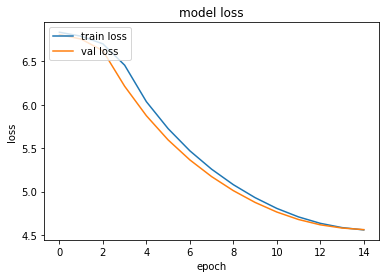


Predictive model running for column  1  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 5.1874 - last_time_step_mae: 0.8154 - val_loss: 5.1904 - val_last_time_step_mae: 0.8283
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 4.9902 - last_time_step_mae: 0.7744 - val_loss: 4.9748 - val_last_time_step_mae: 0.7927
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 4.7662 - last_time_step_mae: 0.7375 - val_loss: 4.7379 - val_last_time_step_mae: 0.7539
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 4.5299 - last_time_step_mae: 0.6993 - val_loss: 4.4961 - val_last_time_step_mae: 0.7146
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 4.2924 - last_time_step_mae: 0.6607 - val_loss: 4.2555 - val_last_time_step_mae: 0.6756
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 4.0564 - last_time_step_mae: 0.6225 - va

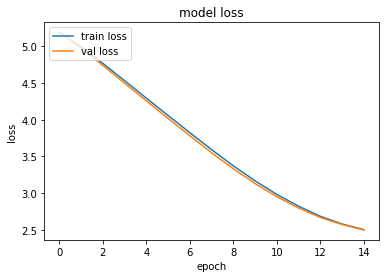


Predictive model running for column  2  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 24.0370 - last_time_step_mae: 4.0453 - val_loss: 24.2996 - val_last_time_step_mae: 4.2493
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.9369 - last_time_step_mae: 3.9739 - val_loss: 24.2576 - val_last_time_step_mae: 4.2425
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.8932 - last_time_step_mae: 3.9670 - val_loss: 24.2120 - val_last_time_step_mae: 4.2345
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.8495 - last_time_step_mae: 3.9601 - val_loss: 24.1687 - val_last_time_step_mae: 4.2271
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.8077 - last_time_step_mae: 3.9533 - val_loss: 24.1273 - val_last_time_step_mae: 4.2199
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.7678 - last_time_step_mae: 

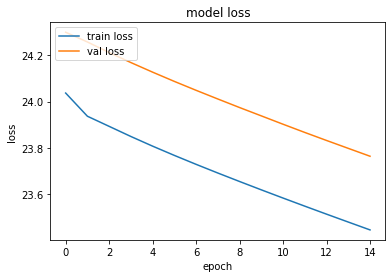


Predictive model running for column  3  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 2.5415 - last_time_step_mae: 0.4368 - val_loss: 2.4313 - val_last_time_step_mae: 0.3293
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 2.3344 - last_time_step_mae: 0.3270 - val_loss: 2.2503 - val_last_time_step_mae: 0.3008
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 2.1123 - last_time_step_mae: 0.2877 - val_loss: 1.9833 - val_last_time_step_mae: 0.2544
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 1.8642 - last_time_step_mae: 0.2373 - val_loss: 1.7840 - val_last_time_step_mae: 0.2111
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 1.7344 - last_time_step_mae: 0.2050 - val_loss: 1.7098 - val_last_time_step_mae: 0.1931
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 1.6921 - last_time_step_mae: 0.1932 - va

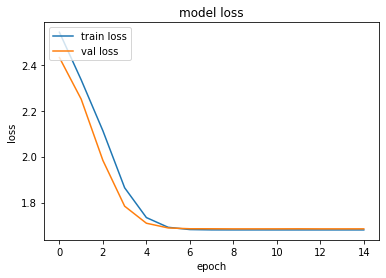


Predictive model running for column  4  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.3741 - last_time_step_mae: 1.3034 - val_loss: 7.2690 - val_last_time_step_mae: 1.2252
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.2140 - last_time_step_mae: 1.1879 - val_loss: 7.2179 - val_last_time_step_mae: 1.2169
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.1673 - last_time_step_mae: 1.1806 - val_loss: 7.1727 - val_last_time_step_mae: 1.2097
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.1215 - last_time_step_mae: 1.1734 - val_loss: 7.1281 - val_last_time_step_mae: 1.2032
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.0771 - last_time_step_mae: 1.1661 - val_loss: 7.0845 - val_last_time_step_mae: 1.1957
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.0347 - last_time_step_mae: 1.1593 - va

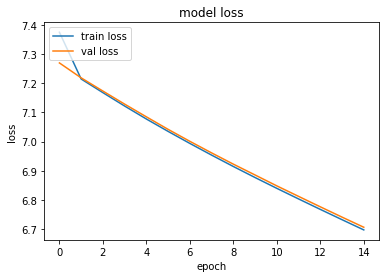

In [71]:
TRTS_results, TRTS_histories = predictive_train_test(ori_set, gen_set, windows=[65,65,65,65,65])

In [72]:
TRTS_results

,y_col,window_length,test_loss,test_metric
0,0,65,6.409595,1.033505
1,1,65,4.032946,0.508837
2,2,65,22.812191,3.261327
3,3,65,1.624338,0.213237
4,4,65,6.459555,0.960781


# TSTR Example

In [ ]:
TSTR = predictive_train_test(gen_set, ori_set, windows=[20,20,20,20,20], epochs=20)

# TRTR vs TSTS Example


Predictive model running for column  0  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 44ms/step - loss: 11.4684 - last_time_step_mae: 0.1900 - val_loss: 12.1745 - val_last_time_step_mae: 0.1712
Epoch 2/10
9/9 [==============================] - 0s 11ms/step - loss: 11.4381 - last_time_step_mae: 0.1580 - val_loss: 12.1440 - val_last_time_step_mae: 0.1391
Epoch 3/10
9/9 [==============================] - 0s 10ms/step - loss: 11.4076 - last_time_step_mae: 0.1258 - val_loss: 12.1131 - val_last_time_step_mae: 0.1067
Epoch 4/10
9/9 [==============================] - 0s 12ms/step - loss: 11.3768 - last_time_step_mae: 0.0931 - val_loss: 12.0820 - val_last_time_step_mae: 0.0736
Epoch 5/10
9/9 [==============================] - 0s 12ms/step - loss: 11.3454 - last_time_step_mae: 0.0597 - val_loss: 12.0507 - val_last_time_step_mae: 0.0398
Epoch 6/10
9/9 [==============================] - 0s 11ms/step - loss: 11.3134 - last_time_step_mae: 0.0256 - val_loss: 12.0189 - 

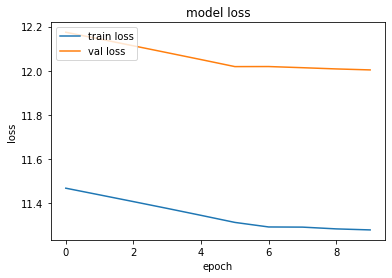


Predictive model running for column  1  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 47ms/step - loss: 7.9625 - last_time_step_mae: 1.2748 - val_loss: 7.6610 - val_last_time_step_mae: 1.2594
Epoch 2/10
9/9 [==============================] - 0s 11ms/step - loss: 7.9432 - last_time_step_mae: 1.2486 - val_loss: 7.6403 - val_last_time_step_mae: 1.2332
Epoch 3/10
9/9 [==============================] - 0s 10ms/step - loss: 7.9222 - last_time_step_mae: 1.2225 - val_loss: 7.6180 - val_last_time_step_mae: 1.2071
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 7.9006 - last_time_step_mae: 1.1963 - val_loss: 7.5972 - val_last_time_step_mae: 1.1810
Epoch 5/10
9/9 [==============================] - 0s 10ms/step - loss: 7.8813 - last_time_step_mae: 1.1701 - val_loss: 7.5805 - val_last_time_step_mae: 1.1547
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 7.8652 - last_time_step_mae: 1.1439 - val_loss: 7.5648 - val_last_time

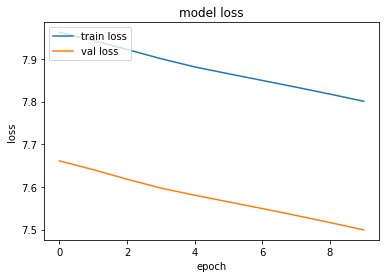


Predictive model running for column  2  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 46ms/step - loss: 33.1944 - last_time_step_mae: 0.1107 - val_loss: 33.7049 - val_last_time_step_mae: 0.0972
Epoch 2/10
9/9 [==============================] - 0s 10ms/step - loss: 33.1719 - last_time_step_mae: 0.0878 - val_loss: 33.6819 - val_last_time_step_mae: 0.0743
Epoch 3/10
9/9 [==============================] - 0s 10ms/step - loss: 33.1491 - last_time_step_mae: 0.0648 - val_loss: 33.6584 - val_last_time_step_mae: 0.0512
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 33.1257 - last_time_step_mae: 0.0416 - val_loss: 33.6347 - val_last_time_step_mae: 0.0279
Epoch 5/10
9/9 [==============================] - 0s 10ms/step - loss: 33.1023 - last_time_step_mae: 0.0183 - val_loss: 33.6112 - val_last_time_step_mae: 0.0046
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 33.0862 - last_time_step_mae: 0.0048 - val_loss: 33.6093 - v

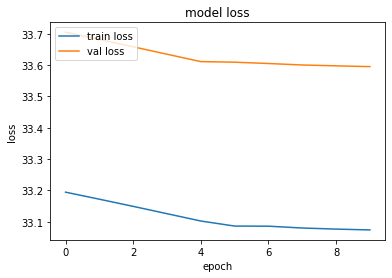


Predictive model running for column  3  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 48ms/step - loss: 4.6300 - last_time_step_mae: 0.9250 - val_loss: 3.9643 - val_last_time_step_mae: 0.9109
Epoch 2/10
9/9 [==============================] - 0s 11ms/step - loss: 4.6033 - last_time_step_mae: 0.9008 - val_loss: 3.9372 - val_last_time_step_mae: 0.8865
Epoch 3/10
9/9 [==============================] - 0s 10ms/step - loss: 4.5762 - last_time_step_mae: 0.8763 - val_loss: 3.9096 - val_last_time_step_mae: 0.8617
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 4.5485 - last_time_step_mae: 0.8514 - val_loss: 3.8817 - val_last_time_step_mae: 0.8366
Epoch 5/10
9/9 [==============================] - 0s 10ms/step - loss: 4.5205 - last_time_step_mae: 0.8261 - val_loss: 3.8536 - val_last_time_step_mae: 0.8110
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 4.4921 - last_time_step_mae: 0.8002 - val_loss: 3.8249 - val_last_time

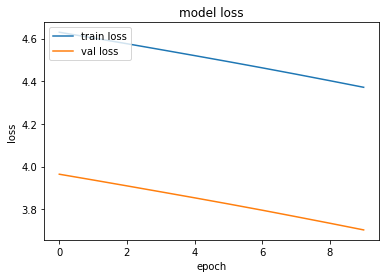


Predictive model running for column  4  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 47ms/step - loss: 10.1705 - last_time_step_mae: 0.1916 - val_loss: 10.9210 - val_last_time_step_mae: 0.1761
Epoch 2/10
9/9 [==============================] - 0s 10ms/step - loss: 10.1537 - last_time_step_mae: 0.1652 - val_loss: 10.9045 - val_last_time_step_mae: 0.1497
Epoch 3/10
9/9 [==============================] - 0s 10ms/step - loss: 10.1372 - last_time_step_mae: 0.1386 - val_loss: 10.8878 - val_last_time_step_mae: 0.1231
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 10.1205 - last_time_step_mae: 0.1122 - val_loss: 10.8718 - val_last_time_step_mae: 0.0966
Epoch 5/10
9/9 [==============================] - 0s 10ms/step - loss: 10.1038 - last_time_step_mae: 0.0856 - val_loss: 10.8560 - val_last_time_step_mae: 0.0698
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 10.0868 - last_time_step_mae: 0.0588 - val_loss: 10.8402 - v

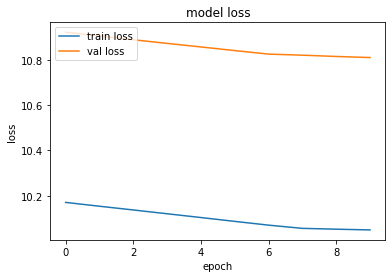


Predictive model running for column  0  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 45ms/step - loss: 13.7707 - last_time_step_mae: 1.1853 - val_loss: 13.3751 - val_last_time_step_mae: 1.1691
Epoch 2/10
9/9 [==============================] - 0s 10ms/step - loss: 13.7451 - last_time_step_mae: 1.1579 - val_loss: 13.3494 - val_last_time_step_mae: 1.1419
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 13.7197 - last_time_step_mae: 1.1306 - val_loss: 13.3237 - val_last_time_step_mae: 1.1146
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 13.6944 - last_time_step_mae: 1.1033 - val_loss: 13.2980 - val_last_time_step_mae: 1.0873
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 13.6694 - last_time_step_mae: 1.0759 - val_loss: 13.2722 - val_last_time_step_mae: 1.0598
Epoch 6/10
9/9 [==============================] - 0s 10ms/step - loss: 13.6441 - last_time_step_mae: 1.0484 - val_loss: 13.2465 - va

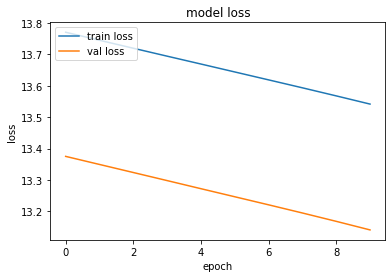


Predictive model running for column  1  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 47ms/step - loss: 8.8560 - last_time_step_mae: 0.1038 - val_loss: 10.0884 - val_last_time_step_mae: 0.0921
Epoch 2/10
9/9 [==============================] - 0s 10ms/step - loss: 8.8468 - last_time_step_mae: 0.0840 - val_loss: 10.0797 - val_last_time_step_mae: 0.0725
Epoch 3/10
9/9 [==============================] - 0s 10ms/step - loss: 8.8376 - last_time_step_mae: 0.0645 - val_loss: 10.0712 - val_last_time_step_mae: 0.0532
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 8.8289 - last_time_step_mae: 0.0454 - val_loss: 10.0629 - val_last_time_step_mae: 0.0343
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 8.8204 - last_time_step_mae: 0.0265 - val_loss: 10.0547 - val_last_time_step_mae: 0.0156
Epoch 6/10
9/9 [==============================] - 0s 10ms/step - loss: 8.8121 - last_time_step_mae: 0.0082 - val_loss: 10.0493 - val_las

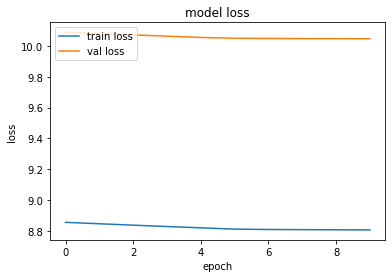


Predictive model running for column  2  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 45ms/step - loss: 31.6027 - last_time_step_mae: 0.0086 - val_loss: 33.9571 - val_last_time_step_mae: 0.0019
Epoch 2/10
9/9 [==============================] - 0s 10ms/step - loss: 31.5995 - last_time_step_mae: 0.0016 - val_loss: 33.9565 - val_last_time_step_mae: 0.0029
Epoch 3/10
9/9 [==============================] - 0s 10ms/step - loss: 31.5992 - last_time_step_mae: 0.0018 - val_loss: 33.9561 - val_last_time_step_mae: 0.0011
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 31.5988 - last_time_step_mae: 0.0011 - val_loss: 33.9553 - val_last_time_step_mae: 8.7634e-04
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 31.5983 - last_time_step_mae: 5.2273e-04 - val_loss: 33.9553 - val_last_time_step_mae: 0.0012
Epoch 6/10
9/9 [==============================] - 0s 10ms/step - loss: 31.5982 - last_time_step_mae: 5.2613e-04 - val_loss:

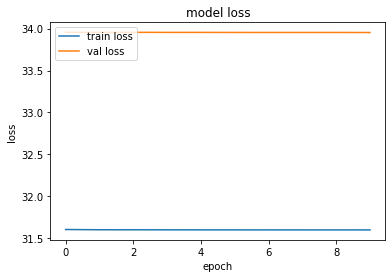


Predictive model running for column  3  with window length  130
Epoch 1/10
9/9 [==============================] - 0s 44ms/step - loss: 3.6316 - last_time_step_mae: 0.5457 - val_loss: 3.3040 - val_last_time_step_mae: 0.5321
Epoch 2/10
9/9 [==============================] - 0s 10ms/step - loss: 3.6087 - last_time_step_mae: 0.5225 - val_loss: 3.2814 - val_last_time_step_mae: 0.5088
Epoch 3/10
9/9 [==============================] - 0s 10ms/step - loss: 3.5858 - last_time_step_mae: 0.4991 - val_loss: 3.2586 - val_last_time_step_mae: 0.4854
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 3.5627 - last_time_step_mae: 0.4757 - val_loss: 3.2356 - val_last_time_step_mae: 0.4619
Epoch 5/10
9/9 [==============================] - 0s 10ms/step - loss: 3.5395 - last_time_step_mae: 0.4520 - val_loss: 3.2121 - val_last_time_step_mae: 0.4381
Epoch 6/10
9/9 [==============================] - 0s 10ms/step - loss: 3.5158 - last_time_step_mae: 0.4281 - val_loss: 3.1876 - val_last_tim

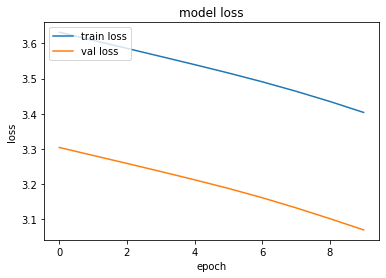


Predictive model running for column  4  with window length  130
Epoch 1/10
9/9 [==============================] - 1s 110ms/step - loss: 10.0485 - last_time_step_mae: 0.3480 - val_loss: 9.3280 - val_last_time_step_mae: 0.3307
Epoch 2/10
9/9 [==============================] - 0s 10ms/step - loss: 10.0260 - last_time_step_mae: 0.3186 - val_loss: 9.3052 - val_last_time_step_mae: 0.3014
Epoch 3/10
9/9 [==============================] - 0s 11ms/step - loss: 10.0035 - last_time_step_mae: 0.2892 - val_loss: 9.2821 - val_last_time_step_mae: 0.2719
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 9.9806 - last_time_step_mae: 0.2597 - val_loss: 9.2589 - val_last_time_step_mae: 0.2424
Epoch 5/10
9/9 [==============================] - 0s 9ms/step - loss: 9.9571 - last_time_step_mae: 0.2302 - val_loss: 9.2350 - val_last_time_step_mae: 0.2128
Epoch 6/10
9/9 [==============================] - 0s 10ms/step - loss: 9.9341 - last_time_step_mae: 0.2004 - val_loss: 9.2112 - val_last_

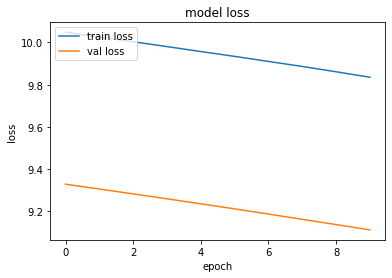

In [73]:
train_ori_set, test_ori_set = train_test_split(ori_set, train_size=0.5)
TRTR_results, TRTR_histories = predictive_train_test(train_ori_set, test_ori_set, epochs=10)

train_gen_set, test_gen_set = train_test_split(gen_set, train_size=0.5)
TSTS_results, TSTS_histories = predictive_train_test(train_gen_set, test_gen_set, epochs=10)

In [74]:
TRTR_results

,y_col,window_length,test_loss,test_metric
0,0,130,11.370266,0.047835
1,1,130,7.723055,1.048997
2,2,130,32.258667,0.178395
3,3,130,4.091468,0.683454
4,4,130,9.902696,0.057075


In [75]:
TSTS_results

,y_col,window_length,test_loss,test_metric
0,0,130,13.447883,0.919504
1,1,130,8.424620,0.000342
2,2,130,31.743883,0.000077
3,3,130,3.078089,0.313256
4,4,130,9.846522,0.055341


### Comparing TRTR vs TSTS results

### SRA